In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import networkx as nx
import matplotlib.pyplot as plt
from scipy import stats
import warnings
from pyvinecopulib import Bicop, BicopFamily

In [2]:
tickers = {
    "BTC": "BTC-USD",
    "ETH": "ETH-USD",
    "NASDAQ-100 ETF": "QQQ",
    "Silver (spot)": "XAG-USD",
    "High-Yield Bond ETF": "HYG",
}

df = yf.download(list(tickers.values()), start="2014-12-01", end="2024-12-31")["Close"]
df.columns = list(tickers.keys())
returns = np.log(df).diff().dropna()

C:\Users\susha\AppData\Local\Temp\ipykernel_171744\2075308445.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(list(tickers.values()), start="2014-12-01", end="2024-12-31")["Close"]
[*********************100%***********************]  5 of 5 completed


In [3]:
returns

,BTC,ETH,NASDAQ-100 ETF,Silver (spot),High-Yield Bond ETF
Date,,,,,
2020-08-13,0.017049,0.092085,-0.002727,0.002278,0.003720
2020-08-14,-0.001296,0.019988,-0.001782,-0.001175,-0.028532
2020-08-18,-0.021709,-0.013741,0.001536,0.009579,0.177760
2020-08-19,-0.019618,-0.041458,-0.002837,-0.006750,0.043120
2020-08-20,0.010161,0.024247,0.003310,0.013777,-0.014597
...,...,...,...,...,...
2023-09-28,0.025063,0.034086,0.004752,0.008330,0.000000
2023-09-29,-0.004073,0.009071,-0.001491,0.000726,0.000000
2023-10-03,-0.003668,-0.004181,-0.010204,-0.017706,0.000000


In [4]:
#probability integrity transform
def pseudo_obs(series):
    r = stats.rankdata(series, method="average")
    return r / (len(series) + 1.0)

U = returns.apply(pseudo_obs, axis=0)

In [5]:
U

,BTC,ETH,NASDAQ-100 ETF,Silver (spot),High-Yield Bond ETF
Date,,,,,
2020-08-13,0.7216,0.9760,0.2272,0.5552,0.6848
2020-08-14,0.4720,0.6816,0.2976,0.4464,0.2432
2020-08-18,0.2128,0.3152,0.6272,0.7520,0.9520
2020-08-19,0.2304,0.1456,0.2224,0.2800,0.8448
2020-08-20,0.6288,0.7136,0.7776,0.8208,0.3216
...,...,...,...,...,...
2023-09-28,0.7936,0.7888,0.8400,0.7328,0.5520
2023-09-29,0.4240,0.5760,0.3264,0.5024,0.5520
2023-10-03,0.4336,0.4256,0.0288,0.1104,0.5520


In [6]:
def fit_bb7_hedge_prob(u1, u2, alpha=0.05, mc_N=20000):
    """
    u1, u2: numpy arrays of pseudo-observations in (0,1)
    Returns: hedge_prob = P(U1 > 1-alpha | U2 < alpha),
             joint_C = C(1-alpha, alpha),
             fam = fitted family name
    """
    import warnings
    from pyvinecopulib import Bicop

    data = np.column_stack([u1, u2]).astype(float)
    data = np.clip(data, 1e-8, 1-1e-8)

    try:
        bicop = Bicop.from_family("bb7")
        bicop.fit(data)
    except Exception as e:
        warnings.warn(f"BB7 fit failed, falling back to automatic selection: {e}")
        bicop = Bicop.from_data(data)
        try:
            bicop.select(data)
        except Exception:
            pass

    # Evaluate C(1-alpha, alpha)
    u_query = np.array([[1.0 - alpha, alpha]], dtype=float)
    try:
        C_1a_a = float(bicop.cdf(u_query, N=mc_N)[0])
    except Exception as e:
        warnings.warn(f"bicop.cdf failed, using empirical fallback for C(1-alpha,alpha): {e}")
        # empirical joint freq: P(U1 > 1-alpha and U2 < alpha) = count / T
        # but we need C(1-alpha, alpha) = P(U1 <= 1-alpha, U2 <= alpha)
        # so compute it directly:
        C_1a_a = ((u1 <= (1-alpha)) & (u2 <= alpha)).sum() / len(u1)

    # compute hedge prob: (alpha - C(1-alpha, alpha)) / alpha
    hedge_p = (alpha - C_1a_a) / alpha
    hedge_p = float(np.clip(hedge_p, 0.0, 1.0))

    fam = bicop.family.name if hasattr(bicop.family, 'name') else str(bicop.family)
    return hedge_p, C_1a_a, fam


In [7]:
assets = U.columns.tolist()
n = len(assets)
H = pd.DataFrame(np.zeros((n, n)), index=assets, columns=assets)  # H.loc[i,j] = P(i hedges j) = P(U_i>1-a | U_j<a)
Cmat = pd.DataFrame(np.zeros((n, n)), index=assets, columns=assets)  # store joint C(1-a,a) or empirical joint freq
family_mat = pd.DataFrame("", index=assets, columns=assets)

for i_idx, i in enumerate(assets):
    for j_idx, j in enumerate(assets):
        if i == j:
            continue
        u_i = U.iloc[:, i_idx].to_numpy()
        u_j = U.iloc[:, j_idx].to_numpy()

        p_hedge, C_1a_a, fam = fit_bb7_hedge_prob(u_i, u_j)
        if p_hedge is None:
            # fallback empirical on PITs
            p_emp, joint_emp = empirical_hedge_prob_from_pits(u_i, u_j, alpha=alpha)
            H.iloc[i_idx, j_idx] = p_emp
            Cmat.iloc[i_idx, j_idx] = joint_emp if joint_emp is not None else 0.0
            family_mat.iloc[i_idx, j_idx] = "empirical"
        else:
            H.iloc[i_idx, j_idx] = p_hedge
            Cmat.iloc[i_idx, j_idx] = C_1a_a
            family_mat.iloc[i_idx, j_idx] = fam

print("\nHedging probability matrix H (P(i > 1-alpha | j < alpha)):\n")
print(H.round(3))
print("\nFitted families (or 'empirical' fallback):\n")
print(family_mat)

C:\Users\susha\AppData\Local\Temp\ipykernel_171744\3114118719.py:18: UserWarning: BB7 fit failed, falling back to automatic selection: from_family(): incompatible function arguments. The following argument types are supported:
    1. from_family(family: pyvinecopulib.BicopFamily = BicopFamily.indep, rotation: int = 0, parameters: numpy.ndarray[dtype=float64, shape=(*, *)] = array([], shape=(0, 0), dtype=float64), var_types: collections.abc.Sequence[str] = ['c', 'c']) -> pyvinecopulib.Bicop

Invoked with types: str
  warnings.warn(f"BB7 fit failed, falling back to automatic selection: {e}")
C:\Users\susha\AppData\Local\Temp\ipykernel_171744\3114118719.py:30: UserWarning: bicop.cdf failed, using empirical fallback for C(1-alpha,alpha): cdf(): incompatible function arguments. The following argument types are supported:
    1. cdf(self, u: numpy.ndarray[dtype=float64, shape=(*, *), order='F']) -> numpy.ndarray[dtype=float64, shape=(*), order='C']

Invoked with types: pyvinecopulib.Bicop, n


Hedging probability matrix H (P(i > 1-alpha | j < alpha)):

                       BTC    ETH  NASDAQ-100 ETF  Silver (spot)  \
BTC                  0.000  0.006           0.006          0.006   
ETH                  0.006  0.000           0.006          0.006   
NASDAQ-100 ETF       0.006  0.038           0.000          0.006   
Silver (spot)        0.006  0.038           0.006          0.000   
High-Yield Bond ETF  0.038  0.006           0.038          0.038   

                     High-Yield Bond ETF  
BTC                                0.071  
ETH                                0.006  
NASDAQ-100 ETF                     0.038  
Silver (spot)                      0.038  
High-Yield Bond ETF                0.000  

Fitted families (or 'empirical' fallback):

                          BTC       ETH NASDAQ-100 ETF Silver (spot)  \
BTC                              gumbel            bb1      gaussian   
ETH                    gumbel                      bb1           bb1   
NASDAQ-100 

In [8]:
G = nx.DiGraph()
G.add_nodes_from(assets)
for i in assets:
    for j in assets:
        if i == j:
            continue
        w = H.loc[i, j]
        if w >= 0.01:
            G.add_edge(j, i, weight=float(w))


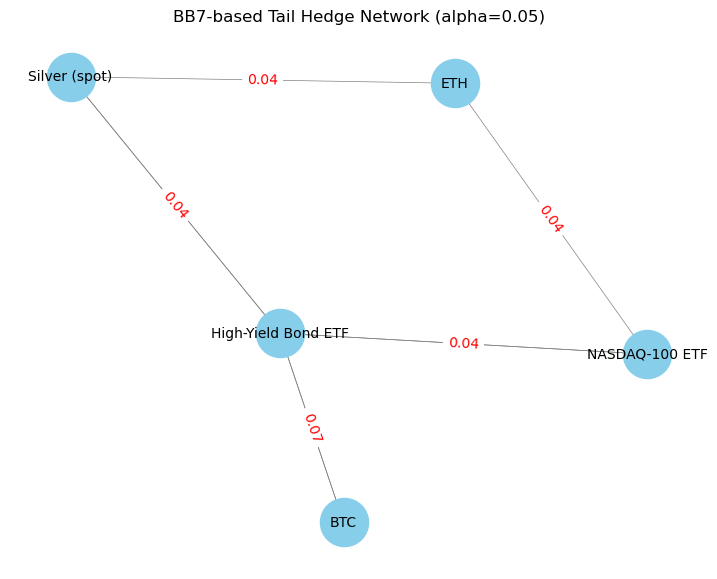

In [9]:
plt.figure(figsize=(9,7))
pos = nx.spring_layout(G, seed=2)
weights = [d['weight'] for (u,v,d) in G.edges(data=True)]
nx.draw_networkx_nodes(G, pos, node_color="skyblue", node_size=1200)
nx.draw_networkx_labels(G, pos, font_size=10)
nx.draw_networkx_edges(G, pos, edge_color='gray',
                       arrowsize=16,
                       width=[max(0.5, 6*w) for w in weights])
edge_labels = {(u,v): f"{d['weight']:.2f}" for u,v,d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')
plt.title(f"BB7-based Tail Hedge Network (alpha=0.05)")
plt.axis('off')
plt.show()